## This notebook is for Linear stability analysis of the circuit, and uses the search result from parameter search in the preliminary analysis. In the previous one, $b_i$, $V_i$, $\mu_i$, $K_{Ai}$, $K_{Bi}$ and $K_{Ci}$ are taken the same. 

![Two nodes - classic](two_nodes_classic.png "Two nodes - classic")

## Here, we extend the search by starting from these points.

In [1]:
%config Completer.use_jedi = False
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Latex

from itertools import product
from scipy.optimize import fsolve
from scipy.linalg import eigvals

from tqdm import tqdm

import sys
sys.path.append("/end/home/rh2310/morpho_repo/amplitude_method")
from utils import *

sys.path.append("/end/home/rh2310/morpho_repo")
from local_utils import *


import warnings
warnings.filterwarnings('ignore')



In [2]:
#init_printing(use_latex='mathjax')#(use_latex=True)

#### Define a list of parameters

In [2]:
A, B = symbols('A, B', real=True, positive = True)

D_A, D_B = symbols('D_A, D_B', real=True, positive = True)

(b_A, b_B,
 V_A, V_B,
K_AA, K_AB, K_BA,
μ_A, μ_B) = symbols(
    'b_A, b_B, V_A, V_B, K_AA, K_AB, K_BA, mu_A, mu_B', 
    real=True, positive = True)

k, n = symbols('k, n', integer=True)

> The PDEs are as follows

<h3><center>$
     \frac{\partial A}{\partial t} = b_A  +   V_A  \frac{1}{1+\left(\frac{K_{AA}}{A }\right)^{n}} \frac{1}{1+\left(\frac{B}{K_{BA} }\right)^{n}} -  \mu_A A + D_A \nabla^2 A,
$</center></h3>

<h3><center>$     \frac{\partial B}{\partial t} = b_B  +   V_B  \frac{1}{1+\left(\frac{K_{AB}}{A }\right)^{n}}  -  \mu_B B + D_B \nabla^2 B,
$</center></h3>



![Two nodes - classic](two_nodes_classic.png "Two nodes - classic")

Then, we define kinetic terms as

<h3><center>$f_A(A, B) = b_A  +   V_A  \frac{1}{1+\left(\frac{K_{AA}}{A }\right)^{n}} \frac{1}{1+\left(\frac{B}{K_{BA} }\right)^{n}} -  \mu_A A$</center></h3>
<h3><center>$f_B(A, B) = b_B  +   V_B  \frac{1}{1+\left(\frac{K_{AB}}{A }\right)^{n}} -  \mu_B B$</center></h3>



In [3]:
def act(x, K, n):
    return 1/(1 + (K/x)**n)

def inh(x, K, n):
    return 1/(1 + (x/K)**n)


fA = b_A + V_A*act(A, K_AA, n)*inh(B, K_BA, n) - μ_A * A
fB = b_B + V_B*act(A, K_AB, n) - μ_B * B

lprint(r"$f_A(A, B) =$ {0}", fA)
lprint(r"$f_B(A, B) =$ {0}", fB)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

#### which as a vector, we can define it like

In [4]:
Kinetic = Matrix([[fA], [fB]])
lprint(r"$\boldsymbol{f}(A, B) =$ {0} ", Kinetic)

<IPython.core.display.Latex object>

# Parameters space

> create a combination of parameters.

In [5]:
params_selction = [0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10, 50, 100, 500]

In [6]:
from itertools import combinations, permutations, product
params = [(index,) + params for index, params in enumerate(product(*[params_selction for _ in range(9)]))]  

In [7]:
params[10]

(10, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.05, 0.01)

In [8]:
len(params)

1000000000

#### First, we find the fix points of the system without diffusion. 


The solution of the above system finds $A^*, B^*$ such that
<center>$f_A(A^*, B^*) = 0$</center>
<center>$f_B(A^*, B^*) = 0$</center>

In [9]:
f1 = lambdify([n, b_A, μ_A, V_A, K_AA, K_AB, 
               b_B, μ_B, V_B, K_BA,
               A,B], 
               fA,
              modules='numpy')

f2 = lambdify([n, b_A, μ_A, V_A, K_AA, K_AB, 
               b_B, μ_B, V_B, K_BA,
               A,B], 
              fB,
              modules='numpy')



def create_func(n, b_A, μ_A, V_A, K_AA, K_AB,
               b_B, μ_B, V_B, K_BA):
    def f_1(args):
        A,B = args
        return (f1(n, b_A, μ_A, V_A, K_AA, K_AB, 
                      b_B, μ_B, V_B, K_BA,
                      A,B),
                f2(n, b_A, μ_A, V_A, K_AA, K_AB, 
                      b_B, μ_B, V_B, K_BA,
                      A,B)) 
    
    return f_1

#### Next, to linearise the PDE system, we find the Jacobian of $(f_A, f_B)$ 

In [10]:
J_jac = Kinetic.jacobian([A, B])
hprint(r"J= \frac{\partial \boldsymbol{f}_i}{\partial u_j} = ", J_jac)
J_jac_func = lambdify([n, b_A, μ_A, V_A, K_AA, K_AB, 
                           b_B, μ_B, V_B, K_BA,
                           A,B], 
                       J_jac,
              modules='numpy')

<IPython.core.display.Latex object>

In [15]:
def single_proccess(args):    
    index, params = args
    
    def find_roots(n_val, b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, 
                          b_B_val, mu_B_val, V_B_val, K_BA_val,
                   verbose=False):    
        func = create_func(n_val, b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, 
                           b_B_val, mu_B_val, V_B_val, K_BA_val,)
        #
        roots_res = []
        for init_vals in product([.1,-.1], repeat=2):        
            roots, d, ier, msg = fsolve(func, init_vals, xtol=1e-7, maxfev=10000,  full_output=1)
            (a_1, b_1) = func(roots)
            if ier == 1 and a_1 < 1e-7 and b_1 < 1e-7:
                roots_res.append(roots)
                return roots_res
        for init_vals in product([1,-1], repeat=2):        
            roots, d, ier, msg = fsolve(func, init_vals, xtol=1e-7, maxfev=10000,  full_output=1)
            (a_1, b_1) = func(roots)
            if ier == 1 and a_1 < 1e-7 and b_1 < 1e-7:
                roots_res.append(roots)
                return roots_res

        for init_vals in product([10,-10], repeat=2):        
            roots, d, ier, msg = fsolve(func, init_vals, xtol=1e-7, maxfev=10000,  full_output=1)
            (a_1, b_1) = func(roots)
            if ier == 1 and a_1 < 1e-7 and b_1 < 1e-7:
                roots_res.append(roots)
                return roots_res

        for init_vals in product([100,-100], repeat=2):        
            roots, d, ier, msg = fsolve(func, init_vals, xtol=1e-7, maxfev=10000,  full_output=1)
            (a_1, b_1) = func(roots)
            if ier == 1 and a_1 < 1e-7 and b_1 < 1e-7:
                roots_res.append(roots)
                return roots_res

        if len(roots_res) == 0:
            if verbose:
                print(msg)
                print("roots:", roots)
                print("values", a_1, b_1)
            return roots_res 
        else:
            roots_res2 = [roots_res[0]]
            for item in roots_res[1:]:
                if np.any(item < 0):
                    continue
                if not np.any([np.isclose(item2, item) for item2 in roots_res2]):
                    roots_res2.append(item)
            return roots_res2 
    
    
    count_unstable = 0
    count_unstable_wrong = 0
    count_supper_stable = 0
    count_supper_stable_wrong = 0
    count_inconclusive = 0
    failed_roots = 0

    
    unstables = []
    unstables_k_max = []
    supper_stables = []
    supper_stables_k_max = []
    unstables_wrong = []
    unstables_k_max_wrong = []
    supper_stables_wrong = []    
    supper_stables_k_max_wrong = []
    inconclusives = []
    inconclusives_k_max = []
    inconclusives_roots = []
    
    
    def append_to_roots(i, param_index, roots, k_max, arr,  arr_k_max, arr_roots):        
        arr.append((i, param_index))
        arr_k_max.append(k_max)
        arr_roots.append(roots)
        
    def append_to(i, param_index, k_max, arr,  arr_k_max):        
        arr.append((i, param_index))
        arr_k_max.append(k_max)
    
    
    D_A_val = 0.01
    D_B_val = 1.0
    n_val = 4

    for i  in range(len(params)):
        (param_index, b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val,
         b_B_val, mu_B_val, V_B_val, K_BA_val) = params[i]    
        #
        roots_all = find_roots(n_val, 
                               b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val,
                               b_B_val, mu_B_val, V_B_val, K_BA_val)
        # check the solution is valid    
        if len(roots_all) == 0:
            failed_roots += 1
            failed_roots
            continue
        else:
            for roots in roots_all:
                J_test = J_jac_func(n_val, 
                                    b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val,
                                    b_B_val, mu_B_val, V_B_val, K_BA_val,
                                    A = roots[0], B = roots[1])
                
                    
                s1 = np.abs(J_test[0, 1])
                s2 = np.abs(J_test[1, 0])

                u1 = J_test[0, 0] + s1
                u2 = J_test[1, 1] + s2    
                l1 = J_test[0, 0] - s1
                l2 = J_test[1, 1] - s2
                
                k1 = np.sqrt(max(0, u1)/D_A_val)
                k2 = np.sqrt(max(0, u2)/D_B_val)
                k_max = max(k1, k2)
                
                det = J_test[0, 0]*J_test[1, 1] - J_test[0, 1]*J_test[1, 0]
                tr = J_test[0, 0] + J_test[1, 1]
                
                if u2 < u1:
                    U_max = u1
                    L_max = l1
                    U_i = u2
                    L_i = l2
                else:
                    U_max = u2
                    L_max = l2
                    U_i = u1
                    L_i = l1
                    
                if U_max < 0:                    
                    if det < 0 or tr > 0:
                        count_supper_stable_wrong += 1
                        append_to(i,param_index, k_max, supper_stables_wrong, supper_stables_k_max__wrong)
                    else:
                        count_supper_stable += 1
                        append_to(i,param_index, k_max, supper_stables, supper_stables_k_max)
                    continue
                
                if L_max <0:
                    count_inconclusive += 1
                    append_to_roots(i,param_index, roots, k_max, inconclusives, inconclusives_k_max, inconclusives_roots)
                    continue
                
                if L_max > U_i:
                    if det > 0 and tr < 0:
                        count_unstable_wrong += 1
                        append_to(i,param_index, k_max, unstables_wrong, unstables_k_max_wrong)
                    else:
                        count_unstable += 1
                        append_to(i,param_index, k_max, unstables, unstables_k_max)
                    continue
                    
                if L_max < L_i:
                    if det > 0 and tr < 0:
                        count_unstable_wrong += 1
                        append_to(i,param_index, k_max, unstables_wrong, unstables_k_max_wrong)
                    else:
                        count_unstable += 1
                        append_to(i,param_index, k_max, unstables, unstables_k_max)
                    continue
                    
                if L_i > 0:                    
                    if det > 0 and tr < 0:
                        count_unstable_wrong += 1
                        append_to(i,param_index, k_max, unstables_wrong, unstables_k_max_wrong)
                    else:
                        count_unstable += 1
                        append_to(i,param_index, k_max, unstables, unstables_k_max)
                    continue
                else:
                    count_inconclusive += 1
                    append_to_roots(i,param_index, roots, k_max, inconclusives, inconclusives_k_max, inconclusives_roots)
                    continue                                                                            
                
    with open(f"./temp/temp_parameters_round_1_index_{index}.npy", 'wb') as f:
        np.save(f, (count_unstable,
                    count_unstable_wrong,
                    count_supper_stable,
                    count_supper_stable_wrong,
                    count_inconclusive,
                    failed_roots,
                    unstables,
                    unstables_k_max,
                    supper_stables,
                    supper_stables_k_max,
                    unstables_wrong,
                    unstables_k_max_wrong,
                    supper_stables_wrong,
                    supper_stables_k_max_wrong,
                    inconclusives,
                    inconclusives_k_max,
                    inconclusives_roots))
    return index
    

In [12]:
len(params)/(50*20)

1000000.0

In [11]:
from multiprocessing import Pool
repeat = 20
num_process = 50*repeat
part_len = 1000000#2087105#2295816#2087105
#indices = [(i*part_len, (i+1)*part_len-1) for i in range(num_process)]
#params_list = [params[i:j,:]  for i,j in indices]
args_list = [(i, params[i*part_len:(i+1)*part_len])  for i in range(num_process)]

In [12]:
del params

In [17]:
for i in range(repeat):
    print(i)
    with Pool(num_process//repeat) as p:
        p.map(single_proccess, args_list[i*50:(i+1)*50])
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [12]:
def load_and_conc(num_process):
    count_unstable = 0
    count_unstable_wrong = 0
    count_supper_stable = 0
    count_supper_stable_wrong = 0
    count_inconclusive = 0
    failed_roots = 0
    failed_roots = 0


    unstables = None
    unstables_k_max = None
    supper_stables = None
    supper_stables_k_max = None
    unstables_wrong = None
    unstables_k_max_wrong = None
    supper_stables_wrong = None
    supper_stables_k_max_wrong = None
    inconclusives = None
    inconclusives_k_max = None
    inconclusives_roots = None
    
    
    for index in range(num_process):
        with open(f"./temp/temp_parameters_round_1_index_{index}.npy", 'rb') as f:
            (count_unstable_i,
            #count_unstable_wrong_i,
            count_supper_stable_i,
            #count_supper_stable_wrong_i,
            count_inconclusive_i,
            failed_roots_i,
            unstables_i,
            unstables_k_max_i,
            supper_stables_i,
            supper_stables_k_max_i,
            unstables_wrong_i,
            unstables_k_max_wrong_i,
            supper_stables_wrong_i,
            supper_stables_k_max_wrong_i,
            inconclusives_i,
            inconclusives_k_max_i,
            inconclusives_roots_i) = np.load(f, allow_pickle=True)
        
        count_unstable += count_unstable_i
        #count_unstable_wrong += count_unstable_wrong_i
        count_supper_stable += count_supper_stable_i
        #count_supper_stable_wrong += count_supper_stable_wrong_i
        count_inconclusive += count_inconclusive_i
        failed_roots += failed_roots_i

        if unstables is None:
            unstables = unstables_i
            unstables_k_max = unstables_k_max_i
            supper_stables = supper_stables_i
            supper_stables_k_max = supper_stables_k_max_i
            unstables_wrong = unstables_wrong_i
            unstables_k_max_wrong = unstables_k_max_wrong_i
            supper_stables_wrong = supper_stables_wrong_i
            supper_stables_k_max_wrong = supper_stables_k_max_wrong_i
            inconclusives = inconclusives_i
            inconclusives_k_max = inconclusives_k_max_i
            inconclusives_roots = inconclusives_roots_i
        else:
            unstables = np.concatenate([unstables, unstables_i])
            unstables_k_max = np.concatenate([unstables_k_max, unstables_k_max_i])
            supper_stables = np.concatenate([supper_stables, supper_stables_i])
            supper_stables_k_max = np.concatenate([supper_stables_k_max, supper_stables_k_max_i])
            unstables_wrong = np.concatenate([unstables_wrong, unstables_wrong_i])
            unstables_k_max_wrong = np.concatenate([unstables_k_max_wrong, unstables_k_max_wrong_i])
            supper_stables_wrong = np.concatenate([supper_stables_wrong, supper_stables_wrong_i])
            supper_stables_k_max_wrong = np.concatenate([supper_stables_k_max_wrong, supper_stables_k_max_wrong_i])
            inconclusives = np.concatenate([inconclusives, inconclusives_i])
            inconclusives_k_max = np.concatenate([inconclusives_k_max, inconclusives_k_max_i])
            inconclusives_roots = np.concatenate([inconclusives_roots, inconclusives_roots_i])
            
    return (count_unstable,
            #count_unstable_wrong,
            count_supper_stable,
            #count_supper_stable_wrong,
            count_inconclusive,
            failed_roots,
            unstables,
            unstables_k_max,
            supper_stables,
            supper_stables_k_max,
            unstables_wrong,
            unstables_k_max_wrong,
            supper_stables_wrong,
            supper_stables_k_max_wrong,
            inconclusives,
            inconclusives_k_max,
            inconclusives_roots) 

In [27]:
(count_unstable,
#count_unstable_wrong,
count_supper_stable,
#count_supper_stable_wrong,
count_inconclusive,
failed_roots,
unstables,
unstables_k_max,
supper_stables,
supper_stables_k_max,
unstables_wrong,
unstables_k_max_wrong,
supper_stables_wrong,
supper_stables_k_max_wrong,
inconclusives,
inconclusives_k_max,
inconclusives_roots) = load_and_conc(num_process)

In [13]:
def load_and_conc(num_process, run_round=1):
    count_unstable = 0
    count_unstable_wrong = 0
    count_supper_stable = 0
    count_supper_stable_wrong = 0
    count_inconclusive = 0
    failed_roots = 0
    failed_roots = 0
    
    for index in range(num_process):
        with open(f"./temp/temp_parameters_round_{run_round}_index_{index}.npy", 'rb') as f:
            (count_unstable_i,
            count_unstable_wrong_i,
            count_supper_stable_i,
            count_supper_stable_wrong_i,
            count_inconclusive_i,
            failed_roots_i,
            _, _, _, _, _, _, _, _, _, _,
            _) = np.load(f, allow_pickle=True)
        
        count_unstable += count_unstable_i
        count_unstable_wrong += count_unstable_wrong_i
        count_supper_stable += count_supper_stable_i
        count_supper_stable_wrong += count_supper_stable_wrong_i
        count_inconclusive += count_inconclusive_i
        failed_roots += failed_roots_i

        
            
    return (count_unstable,
            count_unstable_wrong,
            count_supper_stable,
            count_supper_stable_wrong,
            count_inconclusive,
            failed_roots) 

In [14]:
(count_unstable,
count_unstable_wrong,
count_supper_stable,
count_supper_stable_wrong,
count_inconclusive,
failed_roots) = load_and_conc(num_process)

In [15]:
failed_roots

4058044

In [16]:
count_unstable_wrong, count_supper_stable_wrong

(0, 0)

In [17]:
total = part_len*num_process#
print(f"Of total {total} parameters :")
print("Unstable Gershgoring:",count_unstable, f" {100*count_unstable/total:.2f}%")
print("Supper stable Gershgoring:",count_supper_stable, f" {100*count_supper_stable/total:.2f}%")
print("Wrong Unstable Gershgoring:",count_unstable_wrong, f" {100*count_unstable_wrong/total:.2f}%")
print("Wrong Supper stable Gershgoring:",count_supper_stable_wrong, f" {100*count_supper_stable_wrong/total:.2f}%")
print("Inconclusive:",count_inconclusive, f" {100*count_inconclusive/total:.2f}%")
print("failed_roots:",failed_roots, f" {100*failed_roots/total:.2f}%")
print("--")
print("Unstable G leftovers:",total-count_unstable)
print("Supper stable leftovers:",total-count_supper_stable)
print("Inconclusive leftovers:",total-count_inconclusive)
print("total diff:",total-count_unstable-count_supper_stable-count_inconclusive-failed_roots)

Of total 1000000000 parameters :
Unstable Gershgoring: 4870615  0.49%
Supper stable Gershgoring: 850677030  85.07%
Wrong Unstable Gershgoring: 0  0.00%
Wrong Supper stable Gershgoring: 0  0.00%
Inconclusive: 140394311  14.04%
failed_roots: 4058044  0.41%
--
Unstable G leftovers: 995129385
Supper stable leftovers: 149322970
Inconclusive leftovers: 859605689
total diff: 0


# Check the columns

In [32]:
def single_proccess2(args):    
    index, params = args
    
    with open(f"./temp/temp_parameters_round_1_index_{index}.npy", 'rb') as f:
        (_, _, _, _, _, _, _, _, _, _, _, _, _, _,
        inconclusives_data,
        inconclusives_k_max_data,
        inconclusives_roots_data) = np.load(f,allow_pickle=True)
          
    count_unstable = 0
    count_unstable_wrong = 0
    count_supper_stable = 0
    count_supper_stable_wrong = 0
    count_inconclusive = 0
    failed_roots = 0


    unstables = []
    unstables_k_max = []
    supper_stables = []
    supper_stables_k_max = []
    unstables_wrong = []
    unstables_k_max_wrong = []
    supper_stables_wrong = []
    supper_stables_k_max_wrong = []
    inconclusives = []
    inconclusives_k_max = []
    inconclusives_roots = []
    
    
    def append_to_roots(i, param_index, roots, k_max, arr,  arr_k_max, arr_roots):        
        arr.append((i, param_index))
        arr_k_max.append(k_max)
        arr_roots.append(roots)
        
    def append_to(i, param_index, k_max, arr,  arr_k_max):        
        arr.append((i, param_index))
        arr_k_max.append(k_max)
    
    
    D_A_val = 0.01
    D_B_val = 1.0
    n_val = 4

    for i, (param_index, _) in enumerate(inconclusives_data):
        k_max = inconclusives_k_max_data[i]
        roots = inconclusives_roots_data[i]
        
        (original_param_index, b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val,
         b_B_val, mu_B_val, V_B_val, K_BA_val) = params[param_index]    
        #
        
        J_test = J_jac_func(n_val, 
                            b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val,
                            b_B_val, mu_B_val, V_B_val, K_BA_val,
                            A = roots[0], B = roots[1])


        s1 = np.abs(J_test[1, 0])
        s2 = np.abs(J_test[0, 1])

        u1 = J_test[0, 0] + s1
        u2 = J_test[1, 1] + s2    
        l1 = J_test[0, 0] - s1
        l2 = J_test[1, 1] - s2        

        det = J_test[0, 0]*J_test[1, 1] - J_test[0, 1]*J_test[1, 0]
        tr = J_test[0, 0] + J_test[1, 1]

        if u2 < u1:
            U_max = u1
            L_max = l1
            U_i = u2
            L_i = l2
        else:
            U_max = u2
            L_max = l2
            U_i = u1
            L_i = l1

        if U_max < 0:                    
            if det < 0 or tr > 0:
                count_supper_stable_wrong += 1
                append_to(param_index,original_param_index, k_max, supper_stables_wrong, supper_stables_k_max__wrong)
            else:
                count_supper_stable += 1
                append_to(param_index,original_param_index, k_max, supper_stables, supper_stables_k_max)
            continue

        if L_max <0:
            count_inconclusive += 1
            append_to_roots(param_index,original_param_index, roots, k_max, inconclusives, inconclusives_k_max, inconclusives_roots)
            continue

        if L_max > U_i:
            if det > 0 and tr < 0:
                count_unstable_wrong += 1
                append_to(param_index,original_param_index, k_max, unstables_wrong, unstables_k_max_wrong)
            else:
                count_unstable += 1
                append_to(param_index,original_param_index, k_max, unstables, unstables_k_max)
            continue

        if L_max < L_i:
            if det > 0 and tr < 0:
                count_unstable_wrong += 1
                append_to(param_index,original_param_index, k_max, unstables_wrong, unstables_k_max_wrong)
            else:
                count_unstable += 1
                append_to(param_index,original_param_index, k_max, unstables, unstables_k_max)
            continue

        if L_i > 0:                    
            if det > 0 and tr < 0:
                count_unstable_wrong += 1
                append_to(param_index,original_param_index, k_max, unstables_wrong, unstables_k_max_wrong)
            else:
                count_unstable += 1
                append_to(param_index,original_param_index, k_max, unstables, unstables_k_max)
            continue
        else:
            count_inconclusive += 1
            append_to_roots(param_index,original_param_index, roots, k_max, inconclusives, inconclusives_k_max, inconclusives_roots)
            continue                                                                            
                
    with open(f"./temp/temp_parameters_round_2_index_{index}.npy", 'wb') as f:
        np.save(f, (count_unstable,
                    count_unstable_wrong,
                    count_supper_stable,
                    count_supper_stable_wrong,
                    count_inconclusive,
                    failed_roots,
                    unstables,
                    unstables_k_max,
                    supper_stables,
                    supper_stables_k_max,
                    unstables_wrong,
                    unstables_k_max_wrong,
                    supper_stables_wrong,
                    supper_stables_k_max_wrong,
                    inconclusives,
                    inconclusives_k_max,
                    inconclusives_roots))
    return index

In [33]:
for i in range(repeat):
    print(i)
    with Pool(num_process//repeat) as p:
        p.map(single_proccess2, args_list[i*50:(i+1)*50])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [18]:
(count_unstable2,
count_unstable_wrong2,
count_supper_stable2,
count_supper_stable_wrong2,
count_inconclusive2,
_) = load_and_conc(num_process, run_round=2)

In [19]:
count_unstable_wrong2, count_supper_stable_wrong2

(0, 0)

In [20]:
total2 = count_inconclusive#
print(f"Of total {total2} parameters :")
print("Unstable Gershgoring:",count_unstable2, f" {100*count_unstable2/total2:.2f}%")
print("Supper stable Gershgoring:",count_supper_stable2, f" {100*count_supper_stable2/total2:.2f}%")
print("Wrong Unstable Gershgoring:",count_unstable_wrong2, f" {100*count_unstable_wrong2/total2:.2f}%")
print("Wrong Supper stable Gershgoring:",count_supper_stable_wrong2, f" {100*count_supper_stable_wrong2/total2:.2f}%")
print("Inconclusive:",count_inconclusive2, f" {100*count_inconclusive2/total2:.2f}%")
print("--")
print("Unstable G leftovers:",total2-count_unstable2)
print("Supper stable leftovers:",total2-count_supper_stable2)
print("Inconclusive leftovers:",total2-count_inconclusive2)
print("total diff:",total2-count_unstable2-count_supper_stable2-count_inconclusive2)

Of total 140394311 parameters :
Unstable Gershgoring: 25968  0.02%
Supper stable Gershgoring: 68454498  48.76%
Wrong Unstable Gershgoring: 0  0.00%
Wrong Supper stable Gershgoring: 0  0.00%
Inconclusive: 71913845  51.22%
--
Unstable G leftovers: 140368343
Supper stable leftovers: 71939813
Inconclusive leftovers: 68480466
total diff: 0


In [21]:
print("Combined")
print(f"Of total {total} parameters :")
print("Unstable Gershgoring:",count_unstable+count_unstable2, f" {100*(count_unstable+count_unstable2)/total:.2f}%")
print("Supper stable Gershgoring:",count_supper_stable+count_supper_stable2, f" {100*(count_supper_stable+count_supper_stable2)/total:.2f}%")
print("Wrong Unstable Gershgoring:",count_unstable_wrong+count_unstable_wrong2, f" {100*(count_unstable_wrong+count_unstable_wrong2)/total:.2f}%")
print("Wrong Supper stable Gershgoring:",count_supper_stable_wrong+count_supper_stable_wrong2, f" {100*(count_supper_stable_wrong+count_supper_stable_wrong2)/total:.2f}%")
print("Inconclusive:",count_inconclusive2, f" {100*(count_inconclusive2)/total:.2f}%")
print("failed_roots:",failed_roots, f" {100*failed_roots/total:.2f}%")
print("--")
print("total diff:",total-count_unstable-count_supper_stable-failed_roots-count_unstable2-count_supper_stable2-count_inconclusive2)

Combined
Of total 1000000000 parameters :
Unstable Gershgoring: 4896583  0.49%
Supper stable Gershgoring: 919131528  91.91%
Wrong Unstable Gershgoring: 0  0.00%
Wrong Supper stable Gershgoring: 0  0.00%
Inconclusive: 71913845  7.19%
failed_roots: 4058044  0.41%
--
total diff: 0


# Tightening bounds

In [119]:
def single_proccess3(args):    
    index, params = args
    
    with open(f"./temp/temp_parameters_round_2_index_{index}.npy", 'rb') as f:
        (_, _, _, _, _, _, _, _, _, _, _, _, _, _,
        inconclusives_data,
        inconclusives_k_max_data,
        inconclusives_roots_data) = np.load(f,allow_pickle=True)
          
    count_unstable = 0
    count_unstable_wrong = 0
    count_supper_stable = 0
    count_supper_stable_wrong = 0
    count_inconclusive = 0


    unstables = []
    unstables_k_max = []
    unstables_wrong = []
    unstables_k_max_wrong = []
    supper_stables = []
    supper_stables_k_max = []
    supper_stables_wrong = []    
    supper_stables_k_max_wrong = []
    inconclusives = []
    inconclusives_k_max = []
    inconclusives_roots = []
    
    
    def append_to_roots(i, param_index, roots, k_max, arr,  arr_k_max, arr_roots):        
        arr.append((i, param_index))
        arr_k_max.append(k_max)
        arr_roots.append(roots)
        
    def append_to(i, param_index, k_max, arr,  arr_k_max):        
        arr.append((i, param_index))
        arr_k_max.append(k_max)
    
    
    D_A_val = 0.01
    D_B_val = 1.0
    n_val = 4

    for i, (param_index, _) in enumerate(inconclusives_data):
        k_max = inconclusives_k_max_data[i]
        roots = inconclusives_roots_data[i]
        
        (original_param_index, b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val,
         b_B_val, mu_B_val, V_B_val, K_BA_val) = params[param_index]    
        #
        
        J_test = J_jac_func(n_val, 
                            b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val,
                            b_B_val, mu_B_val, V_B_val, K_BA_val,
                            A = roots[0], B = roots[1])

        det = J_test[0, 0]*J_test[1, 1] - J_test[0, 1]*J_test[1, 0]
        tr = J_test[0, 0] + J_test[1, 1]
        
        

        if J_test[0, 0] < J_test[1, 1]:
            a_ii = J_test[1, 1]
            a_jj  = J_test[0, 0]
            r_i = np.abs(J_test[1, 0])
            r_j = np.abs(J_test[0, 1])
        else:
            a_ii = J_test[0, 0]
            a_jj  = J_test[1, 1]
            r_i = np.abs(J_test[0, 1])
            r_j = np.abs(J_test[1, 0])
                
        if a_ii > 0:
            if (a_jj - a_ii)**2 > 4*r_i*r_j:
                d_i_max = max(np.roots([r_j, a_jj - a_ii, r_i]))
                if d_i_max > (r_i/a_ii):
                    if det > 0 and tr < 0:
                        count_unstable_wrong += 1
                        append_to(param_index,original_param_index, k_max, unstables_wrong, unstables_k_max_wrong)
                    else:
                        count_unstable += 1
                        append_to(param_index,original_param_index, k_max, unstables, unstables_k_max)
                    continue
                else:
                    count_inconclusive += 1
                    append_to_roots(param_index,original_param_index, roots, k_max, inconclusives, inconclusives_k_max, inconclusives_roots)
                    continue                                                                            
                    
            else:
                count_inconclusive += 1
                append_to_roots(param_index,original_param_index, roots, k_max, inconclusives, inconclusives_k_max, inconclusives_roots)
                continue                                                                            
                
        else:
            if (r_i/np.abs(a_ii)) < 1 + (np.abs(a_jj) - r_j)/r_j:
                if det < 0 or tr > 0:
                    count_supper_stable_wrong += 1
                    append_to(i,param_index, k_max, supper_stables_wrong, supper_stables_k_max__wrong)
                else:
                    count_supper_stable += 1
                    append_to(i,param_index, k_max, supper_stables, supper_stables_k_max)
                continue
            else:
                count_inconclusive += 1
                append_to_roots(param_index,original_param_index, roots, k_max, inconclusives, inconclusives_k_max, inconclusives_roots)
                continue                                                                            
                
    with open(f"./temp/temp_parameters_round_3_index_{index}.npy", 'wb') as f:
        np.save(f, (count_unstable,
                    count_unstable_wrong,
                    count_supper_stable,
                    count_supper_stable_wrong,
                    count_inconclusive,
                    unstables,
                    unstables_k_max,
                    supper_stables,
                    supper_stables_k_max,
                    unstables_wrong,
                    unstables_k_max_wrong,
                    supper_stables_wrong,
                    supper_stables_k_max_wrong,
                    inconclusives,
                    inconclusives_k_max,
                    inconclusives_roots))
    return index

In [120]:
for i in range(repeat):
    print(i)
    with Pool(num_process//repeat) as p:
        p.map(single_proccess3, args_list[i*50:(i+1)*50])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [121]:
def load_and_conc3(num_process):
    count_unstable = 0
    count_unstable_wrong = 0
    count_supper_stable = 0
    count_supper_stable_wrong = 0
    count_inconclusive = 0

    
    for index in range(num_process):
        with open(f"./temp/temp_parameters_round_3_index_{index}.npy", 'rb') as f:
            (count_unstable_i,
            count_unstable_wrong_i,
            count_supper_stable_i,
            count_supper_stable_wrong_i,
            count_inconclusive_i,
            _, _, _, _, _, _, _, _, _, _, _) = np.load(f, allow_pickle=True)
        
        count_unstable += count_unstable_i
        count_unstable_wrong += count_unstable_wrong_i
        count_supper_stable += count_supper_stable_i
        count_supper_stable_wrong += count_supper_stable_wrong_i
        count_inconclusive += count_inconclusive_i       
            
    return (count_unstable,
            count_unstable_wrong,
            count_supper_stable,
            count_supper_stable_wrong,
            count_inconclusive) 

In [122]:
(count_unstable3,
count_unstable_wrong3,
count_supper_stable3,
count_supper_stable_wrong3,
count_inconclusive3) = load_and_conc3(num_process)

In [123]:
count_unstable_wrong3, count_supper_stable_wrong3

(0, 0)

In [124]:
total3 = count_inconclusive2#
print(f"Of total {total3} parameters :")
print("Unstable Gershgoring:",count_unstable3, f" {100*count_unstable3/total3:.2f}%")
print("Supper stable Gershgoring:",count_supper_stable3, f" {100*count_supper_stable3/total3:.2f}%")
print("Wrong Unstable Gershgoring:",count_unstable_wrong3, f" {100*count_unstable_wrong3/total3:.2f}%")
print("Wrong Supper stable Gershgoring:",count_supper_stable_wrong3, f" {100*count_supper_stable_wrong3/total3:.2f}%")
print("Inconclusive:",count_inconclusive3, f" {100*(count_inconclusive3)/total3:.2f}%")
print("--")
print("Unstable G leftovers:",total3-count_unstable3)
print("Supper stable leftovers:",total3-count_supper_stable3)
print("Inconclusive leftovers:",total3-count_inconclusive3)
print("total diff:",total3-(count_unstable3+count_supper_stable3+count_inconclusive3))

Of total 71913845 parameters :
Unstable Gershgoring: 307936  0.43%
Supper stable Gershgoring: 64615611  89.85%
Wrong Unstable Gershgoring: 0  0.00%
Wrong Supper stable Gershgoring: 0  0.00%
Inconclusive: 6990298  9.72%
--
Unstable G leftovers: 71605909
Supper stable leftovers: 7298234
Inconclusive leftovers: 64923547
total diff: 0


In [125]:
print("Combined")
print(f"Of total {total} parameters :")
print("Unstable Gershgoring:",count_unstable+count_unstable2+count_unstable3, 
      f" {100*(count_unstable+count_unstable2+count_unstable3)/total:.2f}%")
print("Supper stable Gershgoring:",count_supper_stable+count_supper_stable2+count_supper_stable3,
      f" {100*(count_supper_stable+count_supper_stable2+count_supper_stable3)/total:.2f}%")
print("Wrong Unstable Gershgoring:",count_unstable_wrong+count_unstable_wrong2+count_unstable_wrong3,
      f" {100*(count_unstable_wrong+count_unstable_wrong2+count_unstable_wrong3)/total:.2f}%")
print("Wrong Supper stable Gershgoring:",count_supper_stable_wrong+count_supper_stable_wrong2+count_supper_stable_wrong3,
      f" {100*(count_supper_stable_wrong+count_supper_stable_wrong2+count_supper_stable_wrong3)/total:.2f}%")
print("Inconclusive:",count_inconclusive3, f" {100*(count_inconclusive3)/total:.2f}%")
print("failed_roots:",failed_roots, f" {100*failed_roots/total:.2f}%")
print("--")
print("total diff:",
      total-count_unstable-count_supper_stable-failed_roots-count_unstable2-count_unstable3-count_supper_stable2-count_supper_stable3-count_inconclusive3)

Combined
Of total 1000000000 parameters :
Unstable Gershgoring: 5204519  0.52%
Supper stable Gershgoring: 983747139  98.37%
Wrong Unstable Gershgoring: 0  0.00%
Wrong Supper stable Gershgoring: 0  0.00%
Inconclusive: 6990298  0.70%
failed_roots: 4058044  0.41%
--
total diff: 0


In [88]:
with open(f"./temp/temp_parameters_round_3_index_3.npy", 'rb') as f:
    (_,_,_,_,_,_,_,_,_,
    unstables_wrong,
    unstables_k_max_wrong,
    _, _, _, _, _)=np.load(f, allow_pickle=True)

In [90]:
unstables_wrong_test

[(557477, 3557477)]

In [91]:
(_, b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val,
         b_B_val, mu_B_val, V_B_val, K_BA_val) =args_list[3][1][unstables_wrong_test[0][0]]

In [92]:
def find_roots(n_val, b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, 
                      b_B_val, mu_B_val, V_B_val, K_BA_val,
               verbose=False):    
    func = create_func(n_val, b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, 
                       b_B_val, mu_B_val, V_B_val, K_BA_val,)
    #
    roots_res = []
    for init_vals in product([.1,-.1], repeat=2):        
        roots, d, ier, msg = fsolve(func, init_vals, xtol=1e-7, maxfev=10000,  full_output=1)
        (a_1, b_1) = func(roots)
        if ier == 1 and a_1 < 1e-7 and b_1 < 1e-7:
            roots_res.append(roots)
            return roots_res
    for init_vals in product([1,-1], repeat=2):        
        roots, d, ier, msg = fsolve(func, init_vals, xtol=1e-7, maxfev=10000,  full_output=1)
        (a_1, b_1) = func(roots)
        if ier == 1 and a_1 < 1e-7 and b_1 < 1e-7:
            roots_res.append(roots)
            return roots_res

    for init_vals in product([10,-10], repeat=2):        
        roots, d, ier, msg = fsolve(func, init_vals, xtol=1e-7, maxfev=10000,  full_output=1)
        (a_1, b_1) = func(roots)
        if ier == 1 and a_1 < 1e-7 and b_1 < 1e-7:
            roots_res.append(roots)
            return roots_res

    for init_vals in product([100,-100], repeat=2):        
        roots, d, ier, msg = fsolve(func, init_vals, xtol=1e-7, maxfev=10000,  full_output=1)
        (a_1, b_1) = func(roots)
        if ier == 1 and a_1 < 1e-7 and b_1 < 1e-7:
            roots_res.append(roots)
            return roots_res

    if len(roots_res) == 0:
        if verbose:
            print(msg)
            print("roots:", roots)
            print("values", a_1, b_1)
        return roots_res 
    else:
        roots_res2 = [roots_res[0]]
        for item in roots_res[1:]:
            if np.any(item < 0):
                continue
            if not np.any([np.isclose(item2, item) for item2 in roots_res2]):
                roots_res2.append(item)
        return roots_res2 



In [93]:
roots_all = find_roots(4, 
                               b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val,
                               b_B_val, mu_B_val, V_B_val, K_BA_val)

In [94]:
roots = roots_all[0]
roots

array([ 5.10204267, 76.00960413])

In [95]:
J_test = J_jac_func(4, 
                            b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val,
                            b_B_val, mu_B_val, V_B_val, K_BA_val,
                            A = roots[0], B = roots[1])

In [96]:
J_test

array([[ 5.43062399e-03, -1.81824328e-03],
       [ 9.78401382e+00, -1.00000000e+00]])

In [97]:
det = J_test[0, 0]*J_test[1, 1] - J_test[0, 1]*J_test[1, 0]
tr = J_test[0, 0] + J_test[1, 1]



if J_test[0, 0] < J_test[1, 1]:
    a_ii = J_test[1, 1]
    a_jj  = J_test[0, 0]
    r_i = np.abs(J_test[1, 0])
    r_j = np.abs(J_test[0, 1])
else:
    a_ii = J_test[0, 0]
    a_jj  = J_test[1, 1]
    r_i = np.abs(J_test[0, 1])
    r_j = np.abs(J_test[1, 0])

In [98]:
det, tr

(0.012359093365571287, -0.9945693760102821)

In [99]:
eigvals(J_test)

array([-0.01258585+0.j, -0.98198353+0.j])

In [100]:
(a_jj-a_ii)**2, r_i, r_j, 4*r_i*r_j, (a_jj-a_ii)**2 > 4*r_i*r_j

(1.0108907396563536,
 0.0018182432781146866,
 9.784013816751282,
 0.07115886942115694,
 True)

In [101]:
np.roots([r_i, a_jj - a_ii, r_i])

array([5.52966343e+02, 1.80842833e-03])

In [105]:
d_i_max = max(np.roots([r_j, a_jj - a_ii, r_i]))
d_i_max, (r_i/a_ii), d_i_max > (r_i/a_ii)

(0.10092117331547819, 0.33481295732447147, False)

In [104]:
d = 0.1
print(a_ii - r_i/d, a_ii + r_i/d)
print(a_jj - r_j*d, a_jj + r_j*d)

-0.012751808791428915 0.023613056770864813
-1.9784013816751282 -0.021598618324871754


In [78]:
r_i/a_ii 

0.33481295732447147

-0.0008846809533442858


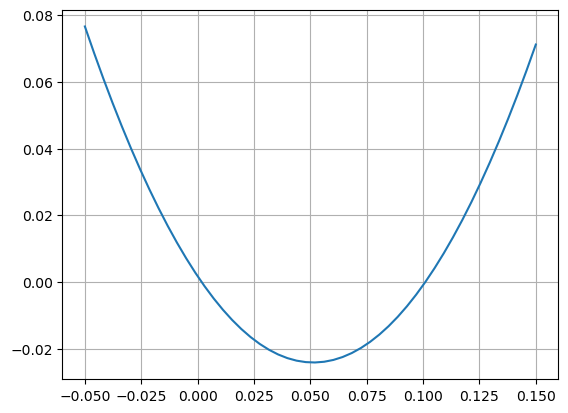

In [74]:
ds = np.linspace(-.05,.15)
f = lambda d: r_j*d*d + (a_jj - a_ii)*d + r_i
plt.plot(ds, f(ds))
plt.grid()
print(f(.1))

## Including the diffusion

In [10]:
J_jac_diff = J_jac - Matrix([[D_A*k**2, 0,        0], 
                             [0,        D_B*k**2, 0],
                             [0,        0,        0],
                           ])
hprint(r"J_{diff}= ", J_jac_diff)

J_jac_diff_func = lambdify([n, b_A, μ_A, V_A, K_AA, K_AB, K_AC,
                            b_B, μ_B, V_B, K_BA, K_BC,
                            b_C, μ_C, V_C, K_CB, K_CC, A,B,C], 
               J_jac_diff,
              modules='numpy')

<IPython.core.display.Latex object>

In [31]:
import warnings
warnings.filterwarnings("ignore")

def single_proccess2(args):
    valid_parameters, valid_roots, k_2_maxs = args
    D_A_val=.01
    D_B_val=1

    turing_dispersions_1 = []
    turing_dispersions_2 = []
    turing_dispersions_3 = []
    turing_parameters = []
    turing_k_max = []
    

    def check_type(item):
        return not isinstance(item, float) and not isinstance(item, int)

    for i  in range(len(valid_parameters)):

        (n_val, b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
         b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
         b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val) = valid_parameters[i]    

        #indices.append(i)
        λ_1, λ_2, λ_3 = list(J_jac_diff.subs(
                              {n:n_val, 
                               b_A:b_A_val, 
                               μ_A:mu_A_val, 
                               V_A:V_A_val,
                               K_AA:K_AA_val, 
                               K_AB:K_AB_val,  
                               K_AC:K_AC_val,
                               b_B:b_B_val, 
                               μ_B:mu_B_val, 
                               V_B:V_B_val,
                               K_BA:K_BA_val, 
                               K_BC:K_BC_val,  
                               b_C:b_C_val, 
                               μ_C:mu_C_val, 
                               V_C:V_C_val,
                               K_CB:K_CB_val, 
                               K_CC:K_CC_val,  
                               D_A: D_A_val , 
                               D_B: D_B_val,
                               A:valid_roots[i][0], 
                               B:valid_roots[i][1], 
                               C:valid_roots[i][2]}
                         ).eigenvals().keys())

        λ_1_func = lambdify([k], 
                             λ_1,
                             modules='numpy')
        λ_2_func = lambdify([k], 
                             λ_2,
                             modules='numpy')
        λ_3_func = lambdify([k], 
                             λ_3,
                             modules='numpy')
        k_max = np.sqrt(k_2_maxs[i])
        ks = np.linspace(0, k_max + 1, 10000).astype(np.complex64) 
        dis1 = λ_1_func(ks)
        if check_type(dis1):
            dis1[np.isinf(np.real(dis1))] = -100

        dis2 = λ_2_func(ks)
        if check_type(dis2):
            dis2[np.isinf(np.real(dis2))] = -100

        dis3 = λ_3_func(ks)
        if check_type(dis2):
            dis3[np.isinf(np.real(dis3))] = -100
        #
        if check_type(dis1) and np.count_nonzero(np.real(dis1) > 0) > 1 and np.real(dis1)[-1] <= 0:
            #turing_parameters_index.append(i)
            turing_dispersions_1.append(dis1)
            turing_dispersions_2.append(dis2)
            turing_dispersions_3.append(dis3)
            turing_parameters.append(valid_parameters[i])
            turing_k_max.append(k_max)
        elif check_type(dis2) and np.count_nonzero(np.real(dis2) > 0) > 1  and np.real(dis2)[-1] <= 0:
            #turing_parameters_index.append(i)
            turing_dispersions_1.append(dis1)
            turing_dispersions_2.append(dis2)
            turing_dispersions_3.append(dis3)
            turing_parameters.append(valid_parameters[i])
            turing_k_max.append(k_max)
        elif check_type(dis3) and np.count_nonzero(np.real(dis3) > 0) > 1  and np.real(dis3)[-1] <= 0:
            #turing_parameters_index.append(i)
            turing_dispersions_1.append(dis1)
            turing_dispersions_2.append(dis2)
            turing_dispersions_3.append(dis3)
            turing_parameters.append(valid_parameters[i])
            turing_k_max.append(k_max)
    return (turing_dispersions_1,
            turing_dispersions_2,
            turing_dispersions_3,
            turing_parameters,
            turing_k_max)

In [32]:
len(valid_roots)

51104279

In [35]:
num_process = 55
part_len = 10000#929740
start = 0
steps = 90
indices = [(start + i*part_len*steps, start + (i+1)*part_len*steps-1) for i in range(num_process)]
#valid_parameters_list = [valid_parameters[i:j,:]  for i,j in indices]
#valid_roots_list = [valid_roots[i:j,:]  for i,j in indices]
args_list = [(valid_parameters[i:j:steps,:], valid_roots[i:j:steps,:], valid_k_max[i:j:steps])  
             for i,j in indices]

In [36]:
indices[-1]

(48600000, 49499999)

In [37]:
with Pool(num_process) as p:
    res2 = p.map(single_proccess2, args_list)

In [38]:
ks = np.linspace(0,10, 10000).astype(np.complex64)
for i in range(len(res2)):
    for j in range(len(res2[i][0])):
        if isinstance(res2[i][0][j], int) or isinstance(res2[i][0][j], float):
            res2[i][0][j] = np.zeros_like(ks)

In [39]:
turing_dispersions_1 = np.concatenate([res2[i][0] for i in range(len(res2)) if len(res2[i][0]) > 0 ])
turing_dispersions_2 = np.concatenate([res2[i][1] for i in range(len(res2)) if len(res2[i][1]) > 0 ])
turing_dispersions_3 = np.concatenate([res2[i][2] for i in range(len(res2)) if len(res2[i][2]) > 0 ])
turing_parameters = np.concatenate([res2[i][3] for i in range(len(res2))  if len(res2[i][3]) > 0])
turing_k_max = np.concatenate([res2[i][4] for i in range(len(res2))  if len(res2[i][4]) > 0])

In [40]:
len(turing_parameters)

87001

In [41]:
#with open('turing_parameters_set_2.npy', 'wb') as f:
#    np.save(f, turing_parameters)
with open('turing_parameters_set_2.npy', 'rb') as f:
    turing_parameters = np.load(f)


# Select the subset that is Turing or Hopf

In [11]:
# Combine three arrays to construct continuous curves
def combine(d1, d2, d3, deltaX):
    dc1 = np.zeros_like(d1)
    dc2 = np.zeros_like(d2)
    dc3 = np.zeros_like(d3)
    
    def distance(y1, y2):
        return (np.real(y1) - np.real(y2))**2 + deltaX**2
    def get_three(i):
        return (d1[i], d2[i], d3[i])                    
        
    # init
    dc1[0], dc2[0], dc3[0] = get_three(0)
    # next closest
    next_i = get_three(1) 
    #print(dc1[0], dc2[0], dc3[0])
    #print(next_i)
    index1 = np.argmin([distance(dc1[0], y2) for y2 in next_i])
    dc1[1] = next_i[index1]
    next_i = tuple(next_i[i] for i in [0,1,2] if i != index1)    
    #print(index1, next_i)
    index2 = np.argmin([distance(dc2[0], y2) for y2 in next_i])
    dc2[1] = next_i[index2]
    dc3[1] = tuple(next_i[i] for i in [0,1] if i != index2)[0]
    #print(dc1[1], dc2[1], dc3[1])     
    for i in range(2, dc1.shape[0]):
        #print()        
        next_i = get_three(i)
        #print(next_i)
        index1 = np.argmin([distance(2*dc1[i-1] - dc1[i-2], y2) for y2 in next_i])
        dc1[i] = next_i[index1]
        next_i = tuple(next_i[i] for i in [0,1,2] if i != index1)
        #print(index1, next_i)
        index2 = np.argmin([distance(2*dc2[i-1] - dc2[i-2], y2) for y2 in next_i])
        dc2[i] = next_i[index2]
        dc3[i] = tuple(next_i[i] for i in [0,1] if i != index2)[0]
        #print(dc1[i], dc2[i], dc3[i])  
    return dc1, dc2, dc3
        
        

In [12]:
def find_roots(n_val, b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
                   b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
                   b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val,
                   verbose=False):    
    func = create_func(n_val, b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
                       b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
                       b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val)
    #
    roots_res = []
    for init_vals in product([.1,-.1], repeat=3):        
        roots, d, ier, msg = fsolve(func, init_vals, xtol=1e-7, maxfev=10000,  full_output=1)
        (a_1, b_1, c_1) = func(roots)
        if ier == 1 and a_1 < 1e-7 and b_1 < 1e-7 and c_1 < 1e-7:
            roots_res.append(roots)
            return roots_res
    for init_vals in product([1,-1], repeat=3):        
        roots, d, ier, msg = fsolve(func, init_vals, xtol=1e-7, maxfev=10000,  full_output=1)
        (a_1, b_1, c_1) = func(roots)
        if ier == 1 and a_1 < 1e-7 and b_1 < 1e-7 and c_1 < 1e-7:
            roots_res.append(roots)
            return roots_res

    for init_vals in product([10,-10], repeat=3):        
        roots, d, ier, msg = fsolve(func, init_vals, xtol=1e-7, maxfev=10000,  full_output=1)
        (a_1, b_1, c_1) = func(roots)
        if ier == 1 and a_1 < 1e-7 and b_1 < 1e-7 and c_1 < 1e-7:
            roots_res.append(roots)
            return roots_res

    for init_vals in product([100,-100], repeat=3):        
        roots, d, ier, msg = fsolve(func, init_vals, xtol=1e-7, maxfev=10000,  full_output=1)
        (a_1, b_1, c_1) = func(roots)
        if ier == 1 and a_1 < 1e-7 and b_1 < 1e-7 and c_1 < 1e-7:
            roots_res.append(roots)
            return roots_res

    if len(roots_res) == 0:
        if verbose:
            print(msg)
            print("roots:", roots)
            print("values", a_1, b_1, c_1)
        return roots_res 
    else:
        roots_res2 = [roots_res[0]]
        for item in roots_res[1:]:
            if np.any(item < 0):
                continue
            if not np.any([np.isclose(item2, item) for item2 in roots_res2]):
                roots_res2.append(item)
        return roots_res2 

def get_dispersions(ks, 
                    n_val, 
                    b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
                    b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
                    b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val):
    
    roots_all = find_roots(n_val, 
         b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
         b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
         b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val)
    dis_list = []

    for roots in roots_all:
        A_star, B_star, C_star = roots
        print(A_star, B_star, C_star)    
        #print(A_star, B_star, C_star)
        λ_1, λ_2, λ_3 = list(J_jac_diff.subs(
                                  {n:n_val, 
                                   b_A:b_A_val, 
                                   μ_A:mu_A_val, 
                                   V_A:V_A_val,
                                   K_AA:K_AA_val, 
                                   K_AB:K_AB_val,  
                                   K_AC:K_AC_val,
                                   b_B:b_B_val, 
                                   μ_B:mu_B_val, 
                                   V_B:V_B_val,
                                   K_BA:K_BA_val, 
                                   K_BC:K_BC_val,  
                                   b_C:b_C_val, 
                                   μ_C:mu_C_val, 
                                   V_C:V_C_val,
                                   K_CB:K_CB_val, 
                                   K_CC:K_CC_val,  
                                   A:A_star, 
                                   B:B_star, 
                                   C:C_star,
                                   D_A:0.01,
                                   D_B:1.0}
                             ).eigenvals().keys())

        λ_1_func = lambdify([k], 
                             λ_1,
                             modules='numpy')
        λ_2_func = lambdify([k], 
                             λ_2,
                             modules='numpy')
        λ_3_func = lambdify([k], 
                             λ_3,
                             modules='numpy')
        
        dis1 = λ_1_func(ks)        
        dis2 = λ_2_func(ks)        
        dis3 = λ_3_func(ks)   

        dis_list.append((dis1, dis2 ,dis3))
        
    return dis_list



In [25]:
def plot_dispersion(index, parameters, k_maxs, ks=None):
    (n_val, 
    b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
    b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
    b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val) = parameters[index]
    print("Parameters - ")
    print("""n, 
             b_A, mu_A, V_A, K_AA, K_AB, K_AC,
             b_B, mu_B, V_B, K_BA, K_BC,
             b_C, mu_C, V_C, K_CB, K_CC""")
    print(n_val)
    print(b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val)
    print(b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val)
    print(b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val)

    if ks is None:
        k_max = k_maxs[index]
        print("k_max:", k_max)
        ks = np.linspace(0, k_max + 1, 10000).astype(np.complex64)
    #ks = np.linspace(0, 5, 100).astype(np.complex64)

    for dis1, dis2, dis3 in get_dispersions(ks, n_val, 
                        b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
                        b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
                        b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val): 
        #dis1, dis2, dis3 = combine(dis1, dis2, dis3, ks[1] - ks[0])
        plt.figure(figsize=(14,5))
        plt.subplot(131)
        plt.title(f"{np.count_nonzero(np.real(dis1) > 0) > 1}")
        plt.plot(ks, np.real(dis1))
        plt.plot(ks, np.imag(dis1))
        plt.xlabel("k")
        plt.grid()
        plt.subplot(132)
        plt.title(f"{np.count_nonzero(np.real(dis2) > 0) > 1}")
        plt.plot(ks, np.real(dis2))
        plt.plot(ks, np.imag(dis2))
        plt.xlabel("k")
        plt.grid()
        plt.subplot(133)
        plt.title(f"{np.count_nonzero(np.real(dis3) > 0) > 1}")
        plt.plot(ks, np.real(dis3))
        plt.plot(ks, np.imag(dis3))
        plt.xlabel("k")
        plt.grid();plt.tight_layout();plt.show()
    


Parameters - 
n, 
             b_A, mu_A, V_A, K_AA, K_AB, K_AC,
             b_B, mu_B, V_B, K_BA, K_BC,
             b_C, mu_C, V_C, K_CB, K_CC
4.0
0.001 0.1 5.0 0.5 0.5 0.5
0.001 0.1 5.0 10.0 0.5
0.1 0.5 0.5 1.0 0.5
k_max: 7.6748052131028475
0.5189490283815226 26.823553100435262 0.2000000013948792


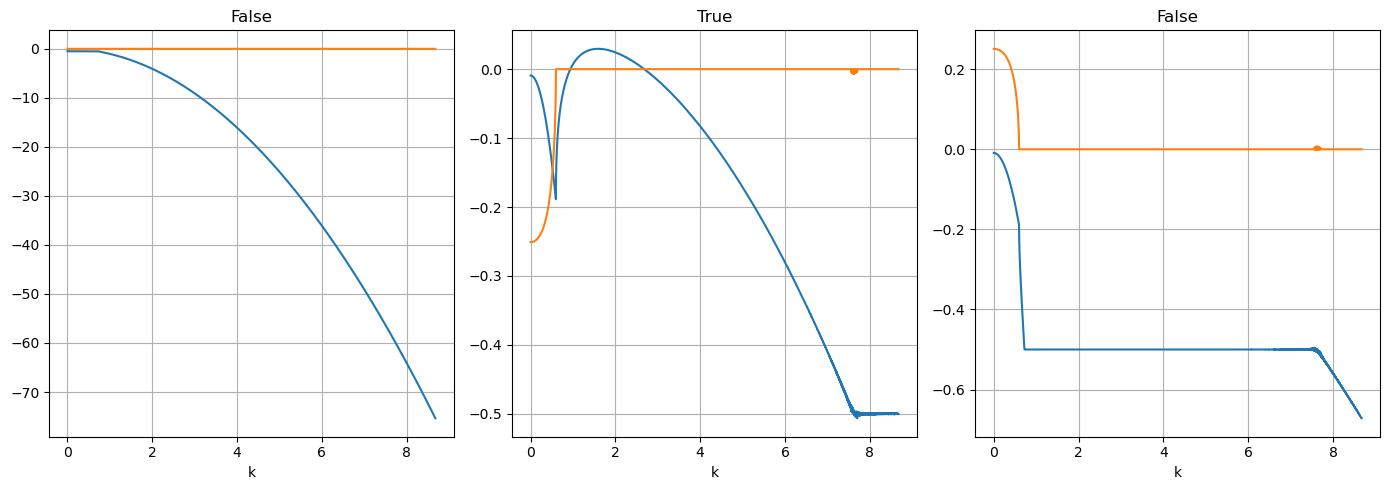

In [45]:
plot_dispersion(0)